In [1]:
"""
You need to run this cell for the code in following cells to work.
"""

# Enable module reloading
%load_ext autoreload
%autoreload 2

import os
os.chdir("..")
import math
import pandas as pd
import datetime
from matplotlib import pyplot as plt
import seaborn as sns
from src.data.analysis import get_outliers
from src.data.preprocessing.utils import merge_data

sns.set(style="whitegrid")

# Data analysis

In [2]:
building_metadata = pd.read_csv('data/building_metadata.csv')

In [3]:
building_metadata

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN
...,...,...,...,...,...,...
1444,15,1444,Entertainment/public assembly,19619,1914.0,NaN
1445,15,1445,Education,4298,NaN,NaN
1446,15,1446,Entertainment/public assembly,11265,1997.0,NaN
1447,15,1447,Lodging/residential,29775,2001.0,NaN


In [4]:
train_data = pd.read_csv('data/train.csv')

In [5]:
train_data

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.000
1,1,0,2016-01-01 00:00:00,0.000
2,2,0,2016-01-01 00:00:00,0.000
3,3,0,2016-01-01 00:00:00,0.000
4,4,0,2016-01-01 00:00:00,0.000
...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750
20216096,1445,0,2016-12-31 23:00:00,4.825
20216097,1446,0,2016-12-31 23:00:00,0.000
20216098,1447,0,2016-12-31 23:00:00,159.575


In [6]:
train_weather = pd.read_csv('data/weather_train.csv')

In [7]:
train_weather

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


# Building analysis

In this section we will analyze buildings.

In [8]:
building_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_use  1449 non-null   object 
 3   square_feet  1449 non-null   int64  
 4   year_built   675 non-null    float64
 5   floor_count  355 non-null    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 68.0+ KB


There are various attributes describing floor area of buildings, floor count, usage of builings and year when they were built.

All those attributes except usage of buildings are numeric attributes. Usage of building is a categorical attribute.

In [9]:
building_metadata.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.000000,355.000000
mean,6.952381,724.000000,92111.776398,1967.957037,3.740845
std,5.003432,418.434583,110769.950997,31.054030,3.333683
min,0.000000,0.000000,283.000000,1900.000000,1.000000
25%,3.000000,362.000000,23012.000000,1949.000000,1.000000
50%,5.000000,724.000000,57673.000000,1970.000000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.000000,5.000000
max,15.000000,1448.000000,875000.000000,2017.000000,26.000000


## Primary use

In [10]:
len(building_metadata.primary_use.unique())

16

In [11]:
building_metadata.primary_use.isna().sum()

0

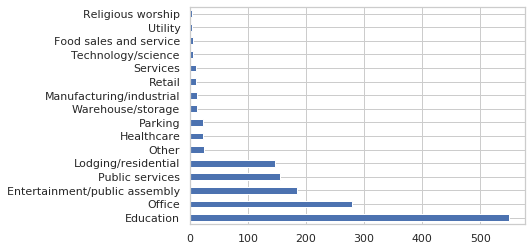

In [12]:
building_metadata.primary_use.value_counts().plot(kind='barh')

We can see that there are 16 different usages of buildings. However only **lodging/residential**, **public services**, **entertainment/public assembly**, **office** and **education** types of usages are more numerous.

We might consider removing buildings with less numerous category of primary use.

## Square feet

This attribute describes total floor area of building summed accross all floors.

In [13]:
building_metadata.square_feet.describe()

count      1449.000000
mean      92111.776398
std      110769.950997
min         283.000000
25%       23012.000000
50%       57673.000000
75%      115676.000000
max      875000.000000
Name: square_feet, dtype: float64

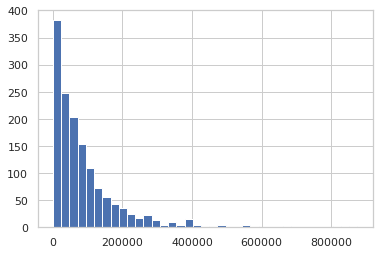

In [14]:
unique_len = len(building_metadata.square_feet.unique())
building_metadata.square_feet.hist(bins=int(math.sqrt(unique_len)))

In [15]:
building_metadata.square_feet.loc[building_metadata.square_feet < 200000].count()

1288

In [16]:
building_metadata.square_feet.loc[(building_metadata.square_feet >= 200000) & \
                                  (building_metadata.square_feet < 400000)].count()

126

In [17]:
building_metadata.square_feet.loc[(building_metadata.square_feet >= 400000) & \
                                  (building_metadata.square_feet < 600000)].count()

25

In [18]:
building_metadata.square_feet.loc[(building_metadata.square_feet >= 600000) & \
                                  (building_metadata.square_feet < 800000)].count()

5

In [19]:
building_metadata.square_feet.loc[building_metadata.square_feet >= 800000].count()

5

From histogram and subsequent calculations we can see that most of the buildings have smaller gross floor area. We can therefore consider all buildings with very large floor area as outliers and remove them from data.

However, we have to look also at floor area of one floor in order to better decide whether building is an outlier or not, because some buildings might be tall and thin.

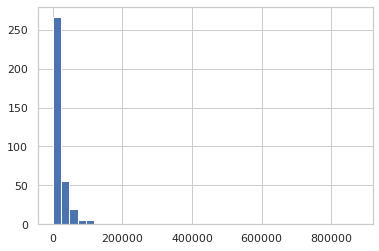

In [20]:
unique_len = len(building_metadata.square_feet.unique())
building_metadata.apply(lambda x: x.square_feet / x.floor_count, axis=1).hist(bins=int(math.sqrt(unique_len)))

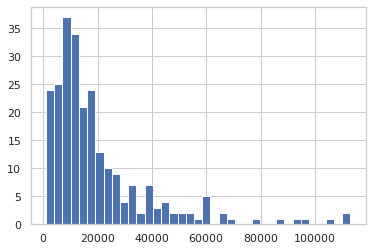

In [21]:
unique_len = len(building_metadata.square_feet.unique())
building_metadata[building_metadata.floor_count > 1].apply(lambda x: x.square_feet / x.floor_count, axis=1).hist(bins=int(math.sqrt(unique_len)))

In these two histograms we can see that most of the buildings have relatively small floor area per floor.

In the second histogram we displayed only buildings which have more than 1 floor. We can see that multi floor buildings are not extremely large.

## Floor count

This attribute describes number of floors buildings have.

In [22]:
building_metadata.floor_count.describe()

count    355.000000
mean       3.740845
std        3.333683
min        1.000000
25%        1.000000
50%        3.000000
75%        5.000000
max       26.000000
Name: floor_count, dtype: float64

In [23]:
building_metadata.floor_count.dropna().count()

355

We can see that out of 1449 buildings only 355 have information about the floor count. Therefore we decided that we will not use this attribute or we will use only buildings for which there is a floor count.

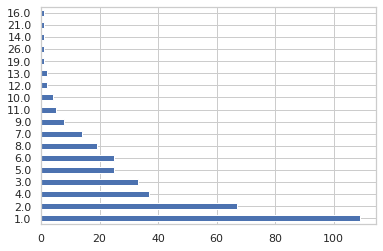

In [24]:
building_metadata.floor_count.dropna().value_counts().plot(kind='barh')

It is possible that Nan values mean that the building has only one floor, because one floor buildings are the most numerous.  However in that case almost all buildings would have only one floor, which means that this attribute would be irrelevant.

We can see that most buildings have one or two floors. Because there are not many buildings with more than 11 floors, we will use only buildings with 11 or less floors if we will use this attribute.

## Year built

This attribute describes in which year buildings were built.

In [25]:
building_metadata.year_built.describe()

count     675.000000
mean     1967.957037
std        31.054030
min      1900.000000
25%      1949.000000
50%      1970.000000
75%      1995.000000
max      2017.000000
Name: year_built, dtype: float64

In [26]:
len(building_metadata.year_built.unique())

117

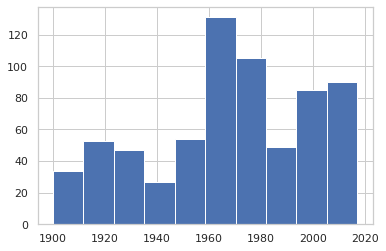

In [27]:
unique_len = len(building_metadata.year_built.unique())
building_metadata.year_built.hist(bins=int(math.sqrt(unique_len)))

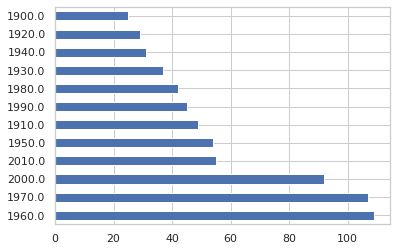

In [28]:
building_metadata.year_built.apply(lambda x: x - x % 10).value_counts().plot(kind='barh')

Most of the buildings, which have information about when building was built is about 40-50 years old. However only half of buildings have this information and we have no option how to fill in missing values, therefore we will not use this attribute or we will use only buildings with year built attribute.

# Weather analysis

In this section we will focus on analysis of weather data.

In [29]:
train_weather

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...
139768,15,2016-12-31 19:00:00,3.0,NaN,-8.0,NaN,NaN,180.0,5.7
139769,15,2016-12-31 20:00:00,2.8,2.0,-8.9,NaN,1007.4,180.0,7.7
139770,15,2016-12-31 21:00:00,2.8,NaN,-7.2,NaN,1007.5,180.0,5.1
139771,15,2016-12-31 22:00:00,2.2,NaN,-6.7,NaN,1008.0,170.0,4.6


In [30]:
train_weather.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

Because cloud coverage and precipitation have almost half of data missing, we will not use these attributes.

Sea level pressure also has lots of missing values. If those are uniformly spread across entire data set, we might be able to fill them in.

## Air temperature

In [31]:
train_weather.air_temperature.describe()

count    139718.000000
mean         14.418106
std          10.626595
min         -28.900000
25%           7.200000
50%          15.000000
75%          22.200000
max          47.200000
Name: air_temperature, dtype: float64

In [32]:
train_weather.air_temperature.isna().sum()

55

There are only 55 missing values of air temperature. We will fill in these values using rolling average.

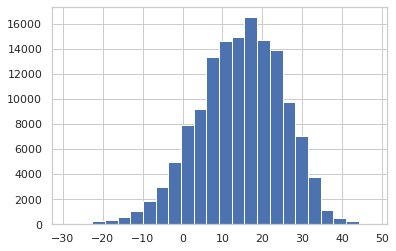

In [33]:
unique_len = len(train_weather.air_temperature.unique())
train_weather.air_temperature.hist(bins=int(math.sqrt(unique_len)))

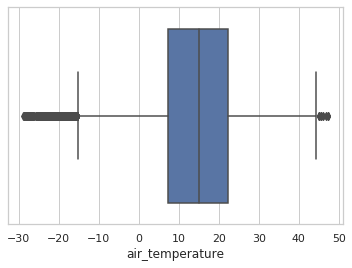

In [34]:
sns.boxplot(x=train_weather.air_temperature)

In [35]:
at_outliers = get_outliers(train_weather, 'air_temperature')
at_outliers

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
21289,2,2016-06-04 22:00:00,45.6,2.0,-3.3,0.0,1005.1,260.0,5.7
21290,2,2016-06-04 23:00:00,45.6,2.0,-3.9,0.0,1004.3,270.0,3.1
21291,2,2016-06-05 00:00:00,45.6,2.0,-5.6,0.0,1003.5,240.0,5.7
21292,2,2016-06-05 01:00:00,45.0,2.0,-6.1,0.0,1003.0,270.0,6.2
21315,2,2016-06-06 00:00:00,45.0,2.0,-6.7,0.0,1001.1,270.0,4.6
...,...,...,...,...,...,...,...,...,...
132415,15,2016-02-19 08:00:00,-15.6,0.0,-17.2,NaN,1033.8,80.0,2.6
132416,15,2016-02-19 09:00:00,-16.1,0.0,-17.8,NaN,1033.8,90.0,3.1
133488,15,2016-04-05 09:00:00,-16.1,0.0,-17.8,NaN,1025.9,0.0,0.0
133489,15,2016-04-05 10:00:00,-16.7,0.0,-18.3,NaN,1026.9,60.0,2.1


Outliers do not seem to be extremely skewed. So we will try models with outliers, without outliers and also with replaced outliers.

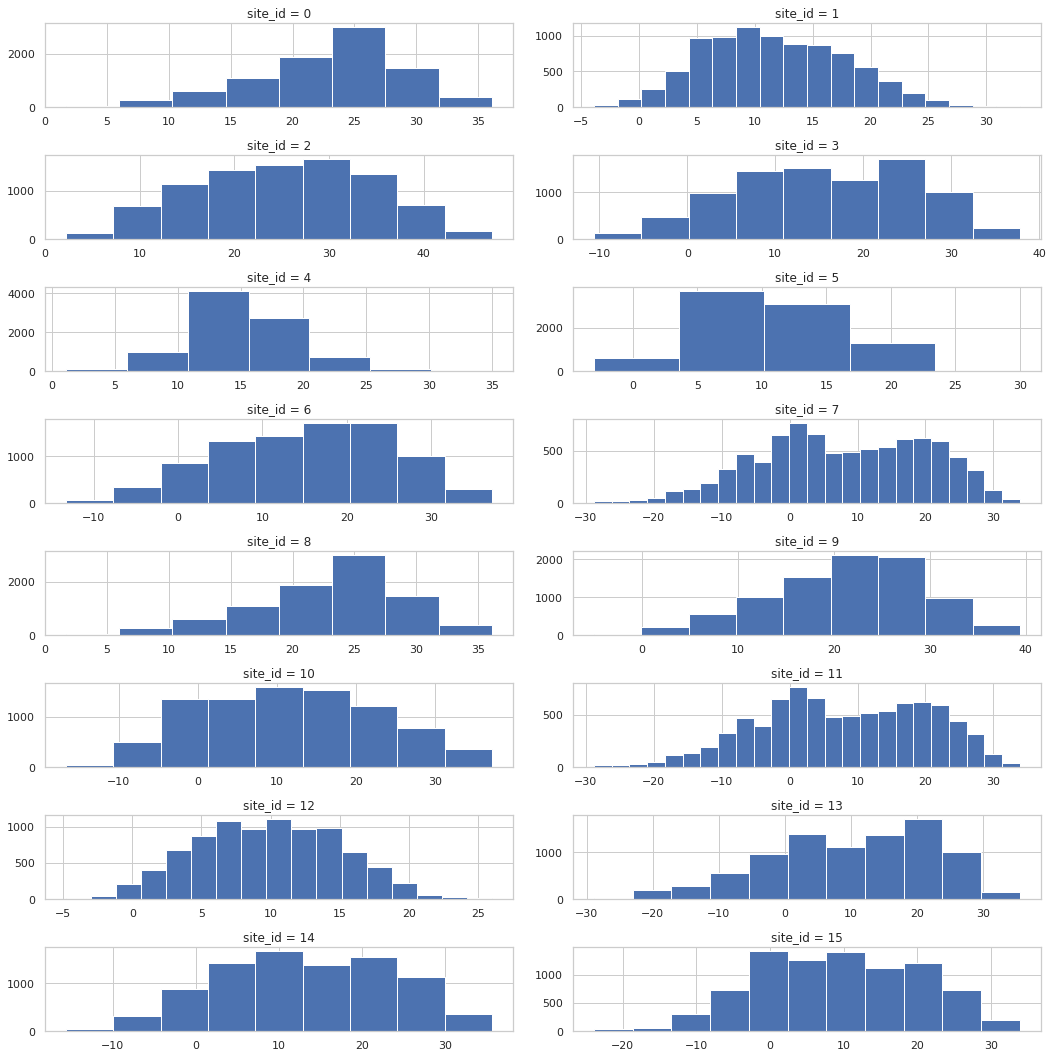

In [36]:
nrows, ncols = 8, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
fig.tight_layout(pad=2)

for i in range(nrows):
    for j in range(ncols):
        site_id = i * ncols + j
        axes[i, j].set_title(f'site_id = {site_id}')
        unique_temps = len(train_weather[train_weather.site_id == site_id].air_temperature.unique())
        train_weather[train_weather.site_id == site_id].air_temperature.hist(bins=int(math.sqrt(unique_temps)), ax=axes[i, j])

We can see that weather stations are in different climate zones, because air temperature distributions are different. However this does not have to be a problem because when there is 0 °C it does not matter whether building is beyond the polar circle or on the equator.

## Dew temperature

In [37]:
train_weather.dew_temperature.describe()

count    139660.000000
mean          7.350158
std           9.790235
min         -35.000000
25%           0.600000
50%           8.300000
75%          14.400000
max          26.100000
Name: dew_temperature, dtype: float64

In [38]:
train_weather.dew_temperature.isna().sum()

113

There are only 113 missing values of dew temperature. We will fill in these values using rolling average.

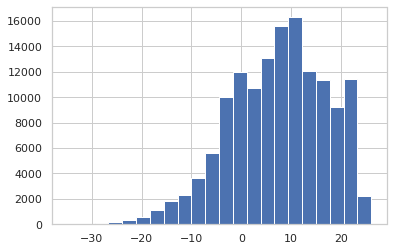

In [39]:
unique_len = len(train_weather.dew_temperature.unique())
train_weather.dew_temperature.hist(bins=int(math.sqrt(unique_len)))

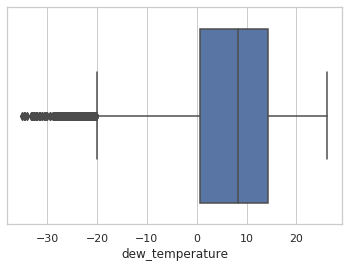

In [40]:
sns.boxplot(x=train_weather.dew_temperature)

In [41]:
at_outliers = get_outliers(train_weather, 'dew_temperature')
at_outliers

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
27382,3,2016-02-13 20:00:00,-5.6,NaN,-20.6,0.0,1025.8,320.0,11.8
27383,3,2016-02-13 21:00:00,-6.1,6.0,-21.1,0.0,1026.4,320.0,10.8
27384,3,2016-02-13 22:00:00,-6.7,4.0,-21.7,0.0,1027.2,320.0,9.8
27385,3,2016-02-13 23:00:00,-7.2,4.0,-22.2,0.0,1029.0,310.0,7.7
27386,3,2016-02-14 00:00:00,-7.8,0.0,-21.1,0.0,1029.9,300.0,6.7
...,...,...,...,...,...,...,...,...,...
132320,15,2016-02-15 08:00:00,-16.7,0.0,-22.8,NaN,1030.8,130.0,4.1
132321,15,2016-02-15 09:00:00,-16.7,0.0,-22.8,NaN,1030.3,120.0,3.1
132322,15,2016-02-15 10:00:00,-15.0,0.0,-22.2,NaN,1029.6,130.0,4.6
132323,15,2016-02-15 11:00:00,-14.4,2.0,-21.7,NaN,1028.9,120.0,5.7


Outliers do not seem to be extremely skewed. So we will try models with outliers, without outliers and also with replaced outliers.

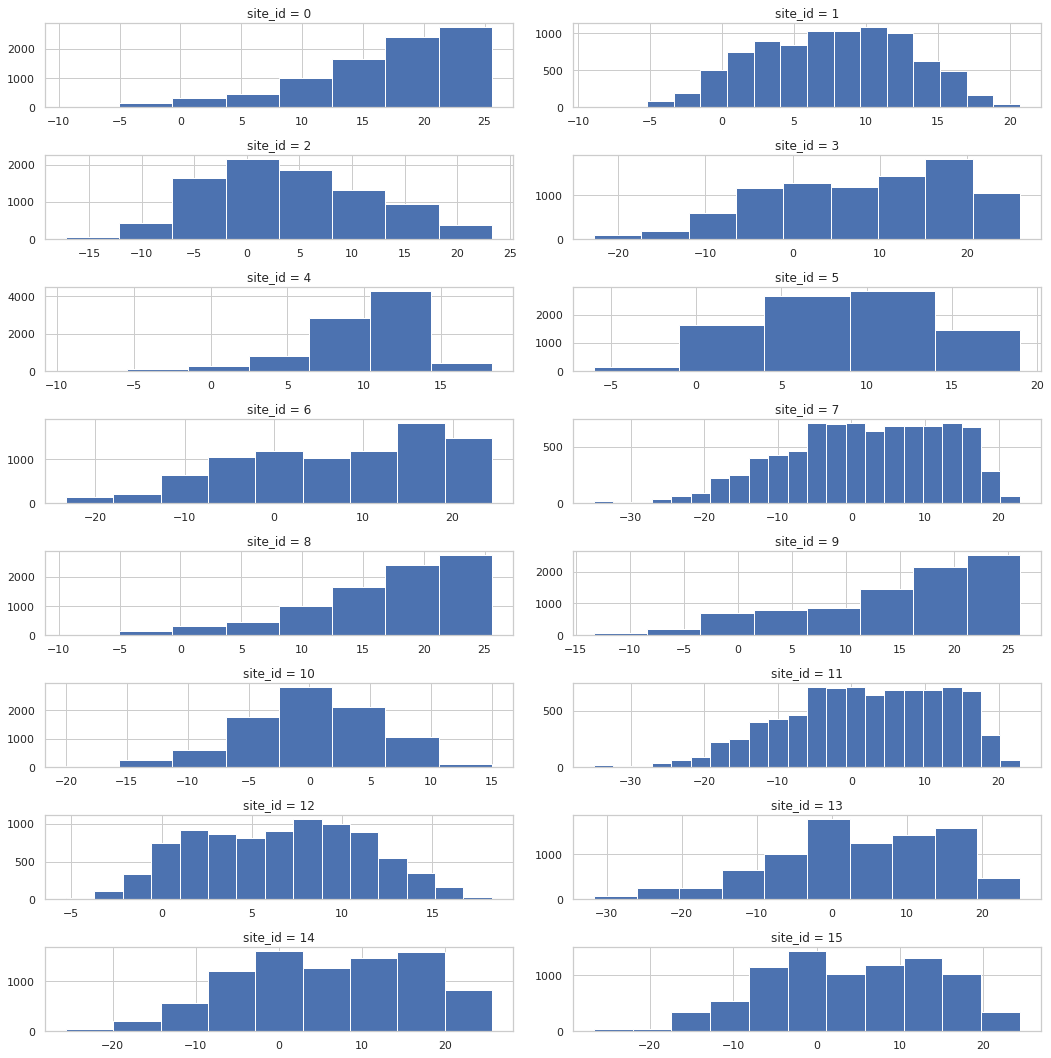

In [42]:
nrows, ncols = 8, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
fig.tight_layout(pad=2)

for i in range(nrows):
    for j in range(ncols):
        site_id = i * ncols + j
        axes[i, j].set_title(f'site_id = {site_id}')
        unique_temps = len(train_weather[train_weather.site_id == site_id].dew_temperature.unique())
        train_weather[train_weather.site_id == site_id].dew_temperature.hist(bins=int(math.sqrt(unique_temps)), ax=axes[i, j])

We can see that weather stations are in different climate zones, because dew temperature distributions are different. However this does not have to be a problem.

## Sea level pressure

This attribute describes sea level pressure.

In [43]:
train_weather.sea_level_pressure.isna().sum()

10618

In [44]:
aux2 = train_weather.copy()
aux2['timestamp'] = aux2['timestamp'].apply(lambda x: x.split()[0])

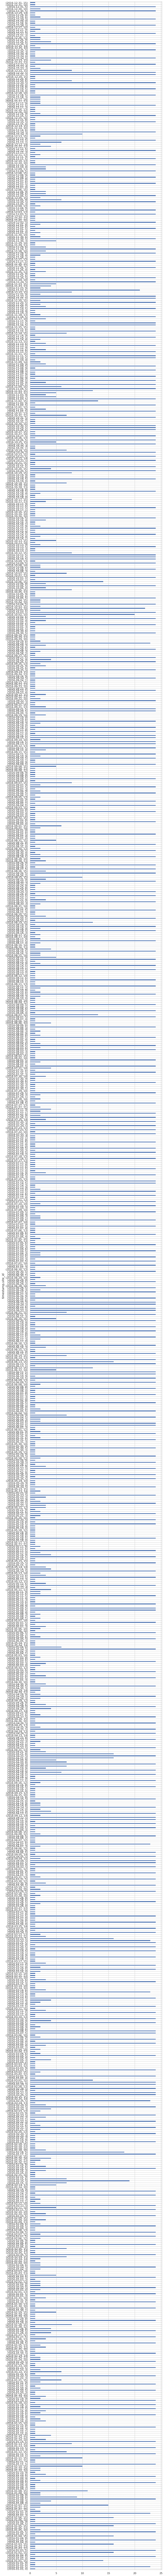

In [45]:
aux3 = aux2[aux2.sea_level_pressure.isna()].copy()
aux3['sea_level_pressure'] = aux3['sea_level_pressure'].apply(lambda x: 1)
aux3.groupby(by=['timestamp', 'site_id']).count()['sea_level_pressure'].plot(kind='barh', figsize=(10, 200))

We can see somewhere that sea level pressure is missing for entire day, sometimes even for a few following days.

This might cause a problem during filling empty values of sea level pressure.

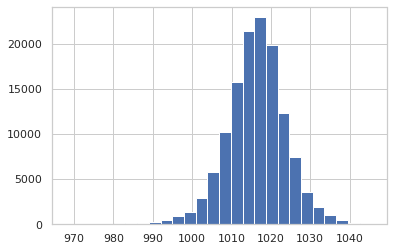

In [46]:
unique_len = len(train_weather.sea_level_pressure.unique())
train_weather.sea_level_pressure.hist(bins=int(math.sqrt(unique_len)))

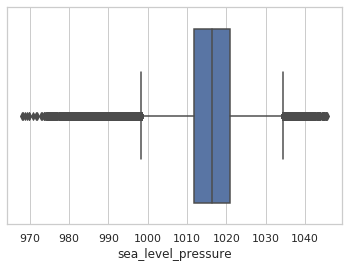

In [47]:
sns.boxplot(x=train_weather.sea_level_pressure)

In [48]:
slp_outliers = get_outliers(train_weather, 'sea_level_pressure')
slp_outliers

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
6727,0,2016-10-07 07:00:00,24.4,NaN,22.8,-1.0,998.0,360.0,14.4
6728,0,2016-10-07 08:00:00,24.4,NaN,22.2,5.0,996.0,350.0,14.4
6729,0,2016-10-07 09:00:00,25.6,NaN,23.3,15.0,994.2,340.0,15.4
6730,0,2016-10-07 10:00:00,25.0,NaN,23.3,20.0,993.3,330.0,13.4
6731,0,2016-10-07 11:00:00,25.0,NaN,23.3,46.0,992.0,320.0,13.9
...,...,...,...,...,...,...,...,...,...
139638,15,2016-12-26 08:00:00,-2.8,0.0,-5.6,NaN,1036.1,120.0,4.1
139639,15,2016-12-26 09:00:00,-2.2,0.0,-6.7,NaN,1035.9,140.0,6.7
139640,15,2016-12-26 10:00:00,-1.7,0.0,-7.8,NaN,1035.0,140.0,6.7
139641,15,2016-12-26 11:00:00,-1.7,0.0,-7.2,NaN,1034.5,140.0,6.2


It is the same case as with air temperature attribute. Outliers do not seem to be extremely skewed. So we will try models with outliers, without outliers and also with replaced outliers.

## Wind speed

In [49]:
train_weather.wind_speed.describe()

count    139469.000000
mean          3.560527
std           2.335874
min           0.000000
25%           2.100000
50%           3.100000
75%           5.000000
max          19.000000
Name: wind_speed, dtype: float64

In [50]:
train_weather.wind_speed.isna().sum()

304

There are only 304 missing values of wind speed. We will fill in these values using rolling average.

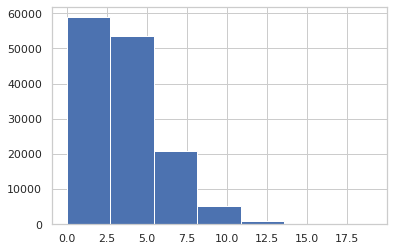

In [51]:
unique_len = len(train_weather.wind_speed.unique())
train_weather.wind_speed.hist(bins=int(math.sqrt(unique_len)))

It seems that wind speed will be usable because there are not many outliers and missing values.

The last column contains too little values compared to other columns. So we will try models both with and without outliers.

## Wind direction

In [52]:
train_weather.wind_direction.describe()

count    133505.000000
mean        180.526632
std         111.523629
min           0.000000
25%          80.000000
50%         190.000000
75%         280.000000
max         360.000000
Name: wind_direction, dtype: float64

In [53]:
train_weather.wind_direction.isna().sum()

6268

There are 6268 missing values of wind direction. We can try to fill in these values using rolling average.

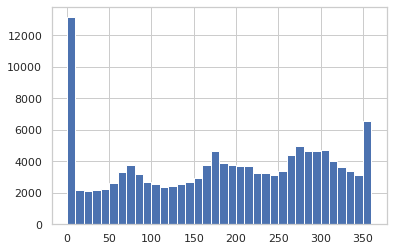

In [54]:
unique_len = len(train_weather.wind_direction.unique())
train_weather.wind_direction.hist(bins=36)

# Data merging

In [55]:
train = merge_data(building=building_metadata, weather=train_weather, meter=train_data)

In [56]:
train

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
1,0,0,2016-01-01 01:00:00,0.00,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,0,0,2016-01-01 02:00:00,0.00,0,Education,7432,2008.0,NaN,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
3,0,0,2016-01-01 03:00:00,0.00,0,Education,7432,2008.0,NaN,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
4,0,0,2016-01-01 04:00:00,0.00,0,Education,7432,2008.0,NaN,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
5,0,0,2016-01-01 05:00:00,0.00,0,Education,7432,2008.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,403,0,2016-12-31 19:00:00,43.66,3,Education,49500,1962.0,NaN,7.8,6.0,-6.1,0.0,1017.8,200.0,8.8
20216096,403,0,2016-12-31 20:00:00,43.64,3,Education,49500,1962.0,NaN,9.4,NaN,-6.7,0.0,1016.7,200.0,11.8
20216097,403,0,2016-12-31 21:00:00,43.89,3,Education,49500,1962.0,NaN,8.9,NaN,-6.1,0.0,1016.3,200.0,8.2
20216098,403,0,2016-12-31 22:00:00,44.37,3,Education,49500,1962.0,NaN,8.9,6.0,-6.1,0.0,1015.4,190.0,7.7


In [57]:
train_building = pd.merge(train_data, building_metadata, on='building_id')
train_building_weather = pd.merge(train_building, train_weather, how='left', on=['site_id', 'timestamp'])

In [58]:
train_building_weather

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.00,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,0,2016-01-01 01:00:00,0.00,0,Education,7432,2008.0,NaN,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,0,2016-01-01 02:00:00,0.00,0,Education,7432,2008.0,NaN,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,0,2016-01-01 03:00:00,0.00,0,Education,7432,2008.0,NaN,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,0,2016-01-01 04:00:00,0.00,0,Education,7432,2008.0,NaN,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,403,0,2016-12-31 19:00:00,43.66,3,Education,49500,1962.0,NaN,9.4,NaN,-6.7,0.0,1016.7,200.0,11.8
20216096,403,0,2016-12-31 20:00:00,43.64,3,Education,49500,1962.0,NaN,8.9,NaN,-6.1,0.0,1016.3,200.0,8.2
20216097,403,0,2016-12-31 21:00:00,43.89,3,Education,49500,1962.0,NaN,8.9,6.0,-6.1,0.0,1015.4,190.0,7.7
20216098,403,0,2016-12-31 22:00:00,44.37,3,Education,49500,1962.0,NaN,8.9,NaN,-6.1,0.0,1015.7,200.0,8.2


# Meter reading analysis

This is a target attribute which describes building energy consumption.

There are four types of energy meters:
* electricity (0),
* chilled water (1),
* steam (2),
* hot water (3).

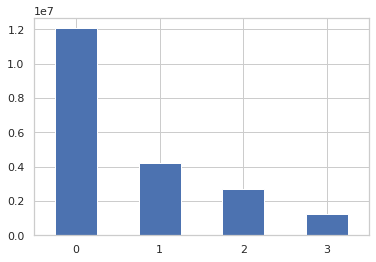

In [59]:
train.meter.value_counts().plot(kind='bar', rot=0)

Because electricity measurement is the most numerous of all meters, we decided to use only electricity meter at the beginning.

## Electricity meter

In this section we will analyze distribution of electricity measurements. 

In [60]:
electricity = train[train.meter == 0]

In [61]:
electricity.meter_reading.describe()

count    1.206091e+07
mean     1.708257e+02
std      3.808343e+02
min      0.000000e+00
25%      1.950000e+01
50%      6.283200e+01
75%      1.700750e+02
max      7.976900e+04
Name: meter_reading, dtype: float64

In [62]:
electricity.meter_reading.isna().sum()

0

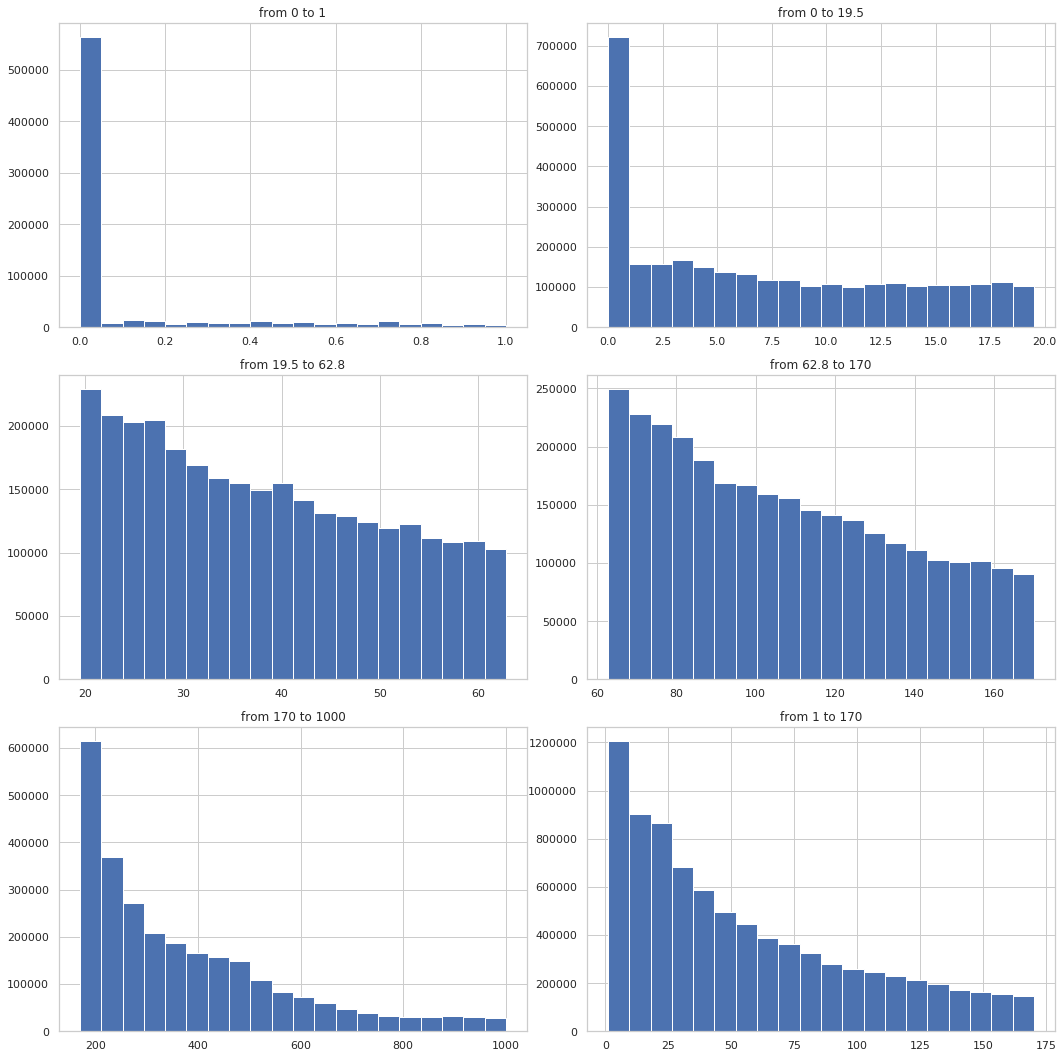

In [63]:
nrows, ncols = 3, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 15))
fig.tight_layout(pad=2)
combs = (
    (0, 1),
    (0, 19.5),
    (19.5, 62.8),
    (62.8, 170),
    (170, 1000),
    (1, 170)
)
for i in range(nrows):
    for j in range(ncols):
        idx = i * ncols + j
        min_, max_ = combs[idx]
        axes[i, j].set_title(f'from {min_} to {max_}')
        electricity_aux = electricity[(electricity.meter_reading >= min_) & (electricity.meter_reading < max_)]
        electricity_aux.meter_reading.hist(bins=20, ax=axes[i, j])

In [64]:
electricity[electricity.meter_reading == 0].meter_reading.count()

530168

In [65]:
electricity[electricity.meter_reading > 1000].meter_reading.count()

304597

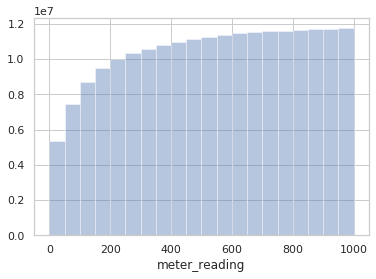

In [66]:
sns.distplot(
    electricity[electricity.meter_reading < 1000].meter_reading,
    bins=20,
    kde=False,
    norm_hist=False,
    hist_kws={'cumulative': True}
)

The most of records have meter reading value smaller than 200. Therefore, we may not use records which have meter reading value above 200.

# Correlations 

In this section we will analyze a correlation between attributes. Our main focus is on the correlation between the meter reading attribute and other attributes.

In [67]:
electricity_selected = electricity[electricity.columns.difference(('meter', 'building_id', 'site_id'))]

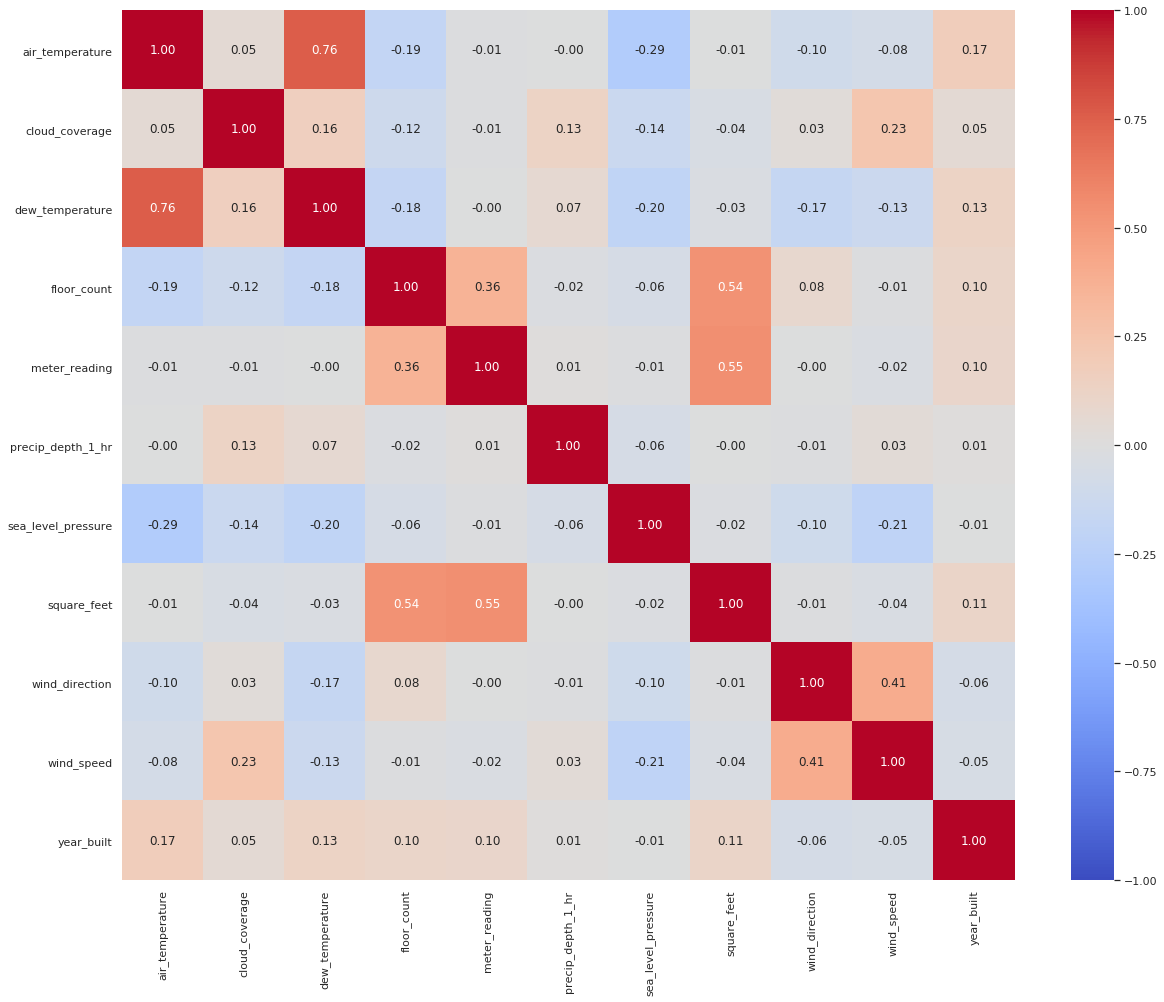

In [68]:
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(electricity_selected.corr(), ax=ax, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)

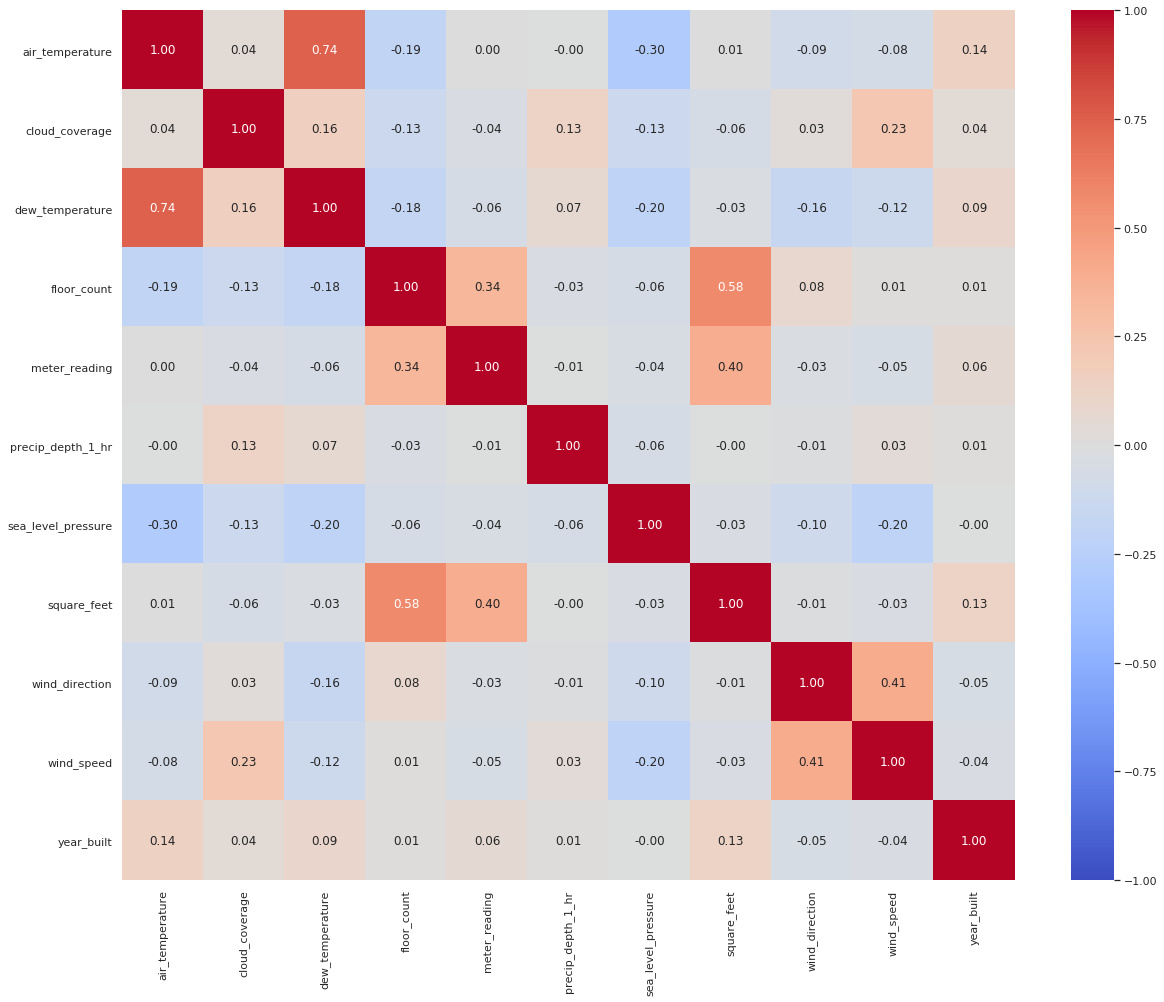

In [69]:
fig, ax = plt.subplots(figsize=(20, 16))
sns.heatmap(
    electricity_selected[electricity_selected.meter_reading <= 200].corr(),
    ax=ax,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1,
    vmax=1
)

We can see that meter reading correlates only with floor count and square feet attributes. However, this correlation can be influenced by using multiple buildings that are placed on different sites or by behavior during the night time.

High correlation of air temperature with dew temperature can cause problems to some machine learning algorithms. We will decide whether to keep only one of these attributes according to algorithm we will use.

# Conclusion

We analyzed all available data about buildings and weather. We mostly focused on outliers and missing values. Some attributes had lots of missing values and therefore we will not use them for training models. We will also try to replace all of the outliers. More detailed conclusions are at the end of analysis of each attribute. 

Next, we analyzed measured values of energy consumption. We found out that electricity measurements are the most numerous. Therefore, we decided to use only these measurements at the beginning.

At the end we analyzed correlations between attributes, while we focused on the correlation between the meter reading attribute and other attributes. We found out that in the data there is a low correlation.